In [15]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim

import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets as datasets

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_dataset = datasets.MNIST(
    root = "./data", train = True, download = True, transform = transform
)

batch_size = 512

train_loader = DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True
)

In [4]:
nz = 128 # 잠재 벡터의 크기를 의미

class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    def forward(self, x):
        # 생성자 네트워크의 반환값은 배치크기 * 1 * 28 * 28(MNIST 크기)
        return self.main(x).view(-1, 1, 28, 28)

In [5]:
# 판별자 네트워크
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
        nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            # 진짜, 가짜 따로 학습함으로 1개의 값으로 출력
            nn.Linear(256, 1),
            # 이미지가 진짜인지 가짜인지 0과 1사이의 값으로 반환
            nn.Sigmoid()
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [7]:
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

losses_g = [] # 생성자 오차 저장
losses_d = [] # 판별자 오차 저장
images = []

In [12]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    fake_label = torch.zeros(b_size, 1).to(device)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_total = (loss_real + loss_fake)/2
    loss_total.backward()
    optimizer.step()
    return loss_total

In [13]:
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [20]:
epochs = 500
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for idx, data in enumerate(train_loader):
        image,_ = data
        data_real = image.to(device)
        b_size = len(data_real)
        
        data_fake = generator(torch.randn(b_size, nz).to(device))
        loss_d += train_discriminator(optim_d, data_real, data_fake)

        data_fake = generator(torch.randn(b_size, nz).to(device))
        loss_g += train_generator(optim_g, data_fake)

    epoch_loss_g = loss_g / idx
    epoch_loss_d = loss_d / idx
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    if epoch%20==0:
        print(f"Epoch {epoch} of {epochs}")
        print(f"Generator loss:{epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

Epoch 20 of 500
Generator loss:2.75507283, Discriminator loss: 0.28083867
Epoch 40 of 500
Generator loss:2.60426021, Discriminator loss: 0.32435343
Epoch 60 of 500
Generator loss:2.29103160, Discriminator loss: 0.33678076
Epoch 80 of 500
Generator loss:2.13568282, Discriminator loss: 0.37382865
Epoch 100 of 500
Generator loss:1.76652670, Discriminator loss: 0.43112102
Epoch 120 of 500
Generator loss:1.65260386, Discriminator loss: 0.46424326
Epoch 140 of 500
Generator loss:1.49890280, Discriminator loss: 0.48699513
Epoch 160 of 500
Generator loss:1.33734226, Discriminator loss: 0.52766508
Epoch 180 of 500
Generator loss:1.32498157, Discriminator loss: 0.54132318
Epoch 200 of 500
Generator loss:1.25443280, Discriminator loss: 0.54884541
Epoch 220 of 500
Generator loss:1.23234773, Discriminator loss: 0.55301899
Epoch 240 of 500
Generator loss:1.15455604, Discriminator loss: 0.57293969
Epoch 260 of 500
Generator loss:1.11352980, Discriminator loss: 0.58319438
Epoch 280 of 500
Generator lo

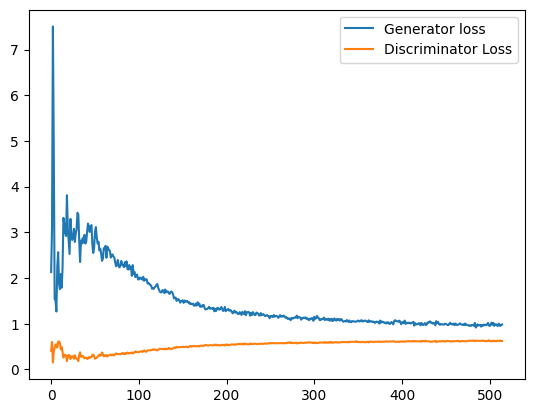

In [21]:
plt.figure()
plt.plot(torch.Tensor(losses_g), label = 'Generator loss')
plt.plot(torch.Tensor(losses_d), label = 'Discriminator Loss')
plt.legend()

In [25]:
from torchvision.utils import save_image

save_image(data_fake, 'result_fake.png', nrow=10, normalize = True)
save_image(data_real, 'result_real.png', nrow=10, normalize = True)

In [24]:
# 생성 이미지
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28, 28))
    plt.imshow(fake_images_img, cmap='gray')
    plt.show()

NameError: name 'fake_images' is not defined